# Notebook 04 – Neural Network Model

In [14]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier


## Load data

In [15]:
data_path = r"C:/Users/USER/PycharmProjects/ML/data/Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)

## Data Cleaning

In [16]:
df = df.drop("customerID", axis=1)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

## Load Preprocessor

In [17]:
preprocessor = joblib.load("results/preprocessor.pkl")
print("Preprocessor loaded successfully.")

Preprocessor loaded successfully.


## Split Features

In [18]:

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_pre = preprocessor.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_pre, y, test_size=0.2, random_state=42, stratify=y
)

## Apply SMOTE to Handle Imbalance

In [19]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("SMOTE applied. New training shape:", X_train_res.shape)

SMOTE applied. New training shape: (8278, 45)


## Build Neural Network Function

In [20]:
def build_nn(hidden_units=32, dropout_rate=0.3):
    model = Sequential()
    model.add(Input(shape=(X_train_res.shape[1],)))

    model.add(Dense(hidden_units, activation="relu"))
    model.add(Dropout(dropout_rate))

    model.add(Dense(hidden_units // 2, activation="relu"))
    model.add(Dropout(dropout_rate))

    # IMPORTANT: correct output layer for binary classification
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


## Wrap with KerasClassifier

In [21]:

keras_clf = KerasClassifier(
    model=build_nn,
    verbose=0,
    epochs=30,
    batch_size=32,
    hidden_units=32,
    dropout_rate=0.3,
    random_state=42
)

## Hyperparameter Grid

In [22]:
param_dist = {
    "hidden_units": [32, 64, 128],
    "dropout_rate": [0.2, 0.3],
    "batch_size": [16, 32],
    "epochs": [30, 50]
}

rs_nn.fit(X_train_res, y_train_res)

print("Best NN parameters:", rs_nn.best_params_)
print("Best CV ROC AUC:", rs_nn.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\

[CV] END batch_size=32, dropout_rate=0.3, epochs=50, hidden_units=64; total time=  19.1s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=32, dropout_rate=0.3, epochs=50, hidden_units=64; total time=  17.1s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=32, dropout_rate=0.3, epochs=50, hidden_units=64; total time=  16.7s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=16, dropout_rate=0.3, epochs=30, hidden_units=32; total time=  17.8s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=16, dropout_rate=0.3, epochs=30, hidden_units=32; total time=  18.4s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=16, dropout_rate=0.3, epochs=30, hidden_units=32; total time=  18.6s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=32, dropout_rate=0.2, epochs=30, hidden_units=64; total time=  22.4s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=32, dropout_rate=0.2, epochs=30, hidden_units=64; total time=  22.3s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=32, dropout_rate=0.2, epochs=30, hidden_units=64; total time=  10.4s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=32, dropout_rate=0.3, epochs=30, hidden_units=16; total time=  10.2s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=32, dropout_rate=0.3, epochs=30, hidden_units=16; total time=  10.2s


C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\PycharmProjects\Telco_Churn_ML_Project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = 

[CV] END batch_size=32, dropout_rate=0.3, epochs=30, hidden_units=16; total time=  10.3s
Best NN parameters: {'hidden_units': 64, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 32}
Best CV ROC AUC: nan


## Evaluate on test set

Neural Network Accuracy: 0.7444996451383961

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81      1035
           1       0.51      0.71      0.59       374

    accuracy                           0.74      1409
   macro avg       0.70      0.73      0.70      1409
weighted avg       0.78      0.74      0.76      1409



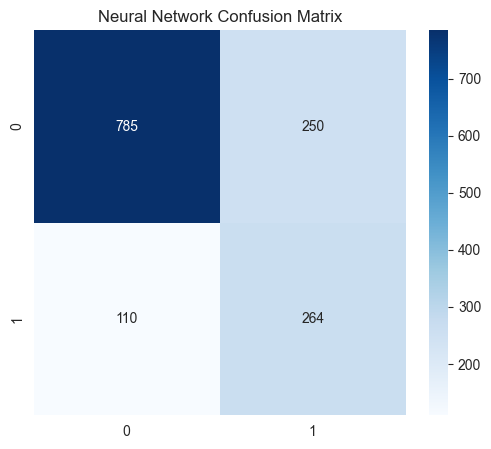

In [23]:
y_pred_nn = rs_nn.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)

print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Blues')
plt.title("Neural Network Confusion Matrix")
plt.show()


## Save Model

In [25]:
best_model = rs_nn.best_estimator_.model_

# Save the model in Keras format
best_model.save("results/nn_model.h5")
print("Neural Network model saved as nn_model.h5")

Neural Network model saved as nn_model.h5
